# I. Module imports

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# II. Define or import all pre-processing functions

In [2]:
'''Here we are re-defining all the functions. A better way is to
save them inside a separate script and then import them'''

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

# III. Read in data and preprocess

In [3]:
'''Define a variable that points to the folder where data is stored'''
my_path = '/Users/ram/Desktop/Data'

In [4]:
'''We will use the Titanic test set we made previously 
(Titanic_test.csv). Read in the csv formatted data and, check the dataframe's
shape and top few rows of data'''

mydf_test = pd.read_csv(f'{my_path}/Titanic_test.csv')
print(mydf_test.shape)
mydf_test.head(3)

(196, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1114,0,2,"Cook, Mrs. (Selena Rogers)",female,22.0,0,0,W./C. 14266,10.5000,F33,S
1,1115,0,3,"Karlsson, Mr. Einar Gervasius",male,21.0,0,0,350053,7.7958,NaN,S
2,1116,1,1,"Candee, Mrs. Edward (Helen Churchill Hungerford)",female,53.0,0,0,PC 17606,27.4458,NaN,C


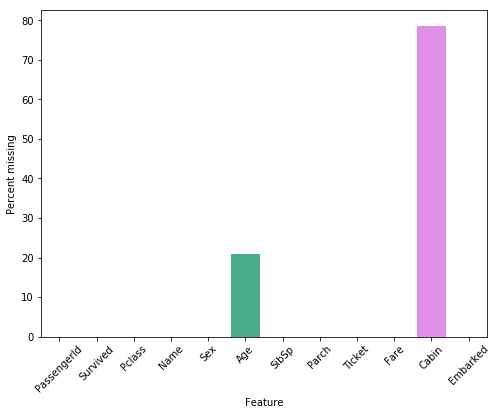

In [5]:
''' (1) Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_test.isnull().sum()/len(mydf_test)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [6]:
'''Drop cabin column'''

mydf_test_1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test_1.shape)
mydf_test_1.head(2)

(196, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1114,0,2,"Cook, Mrs. (Selena Rogers)",female,22.0,0,0,W./C. 14266,10.5000,S
1,1115,0,3,"Karlsson, Mr. Einar Gervasius",male,21.0,0,0,350053,7.7958,S


In [7]:
'''(3) Map categories to numbers for test set'''
mydf_test_2 = str_to_cat(mydf_test_1)

In [8]:
#Make sure category mapping are consistent across the training and test datasets

print(mydf_test_2.Sex.cat.categories)

Index(['female', 'male'], dtype='object')


In [9]:
#Make sure category mapping are consistent across the two data sets
print(mydf_test_2.Embarked.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')


In [10]:
''' (4) Let's proceed with the imputation and convert strings into 
numbers for the test set. Use my_table from training set.'''

my_table = {'Age': 28.0}
mydf_test_3,my_table1 = mydf_preprocessor(mydf_test_2,
                                         null_table = my_table)
print(mydf_test_3.shape)
mydf_test_3.head(3)

(196, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
0,1114,0,2,36,1,22.0,0,0,183,10.5000,3,False
1,1115,0,3,91,2,21.0,0,0,104,7.7958,3,False
2,1116,1,1,24,1,53.0,0,0,161,27.4458,1,False


In [11]:
'''(5) Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y_test = mydf_test_3["Survived"]
X_test = mydf_test_3.drop(["Survived"],axis = 1)

print(X_test.shape,Y_test.shape)

(196, 11) (196,)


In [12]:
'''(6) Standardize the continuous variables. Read in the joblib
scaler from the previous notebook'''

scaler_loaded = joblib.load('/Users/ram/Desktop/DS 2019/scaler_trainset/scaler_train.sav')
X_test[["Age","Fare"]] = pd.DataFrame(scaler_loaded.transform(X_test[["Age","Fare"]]))
X_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
0,1114,2,36,1,-0.571942,0,0,183,-0.43642,3,False
1,1115,3,91,2,-0.648410,0,0,104,-0.49084,3,False


# Load the saved k-NN model and evaluate on the test set !

In [13]:
#Let's load the saved k-NN model and test it out.

kNN_loaded = joblib.load('/Users/ram/Desktop/DS 2019/knn_model/knn_model_final.sav')
Y_test_pred = kNN_loaded.predict(X_test)
print(accuracy_score(Y_test,Y_test_pred),
      matthews_corrcoef(Y_test,Y_test_pred),f1_score(Y_test,Y_test_pred))

0.5969387755102041 0.14268090238677017 0.3247863247863248


'''Almost 60%. We can do better ! How? (1) Feature Engineering (check out
some of the top rated Kaggle Kernels for this datasets, (2) Try other ML models'''